
# Miniproject 2: Chatbot

## Introduction

### Description

Developing a model employing ANN on real-world data requires going through several major steps, each of which with 
important design choices that directly impact the final results. 
In this project, we guide you through these choices starting from a large database of 
[conversations](http://parl.ai/downloads/personachat/personachat.tgz) to a functional chatbot. 

### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/).
- You should know the concepts "recurrent neural networks", "LSTM", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will be guided through a data processing procedure and understand the importance of design choices in ANN modeling
- You will learn how to define recurrent neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed in the lecture, like "overfitting", "LSTM network", and "Generative model".
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night and make sure you save (and load) your data and models.

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. 
We will only do random tests of your code and not re-run the full notebook. 
Please ensure that your notebook is fully executed before handing it in. 

### Submission 

You should submit your notebook through the Moodle page submission tool. You should work in teams of two people and each member should submit the same notebook to Moodle.



## Functions and imports

For your convenience we import some libraries and provide some functions below. Fill in your names, sciper numbers and run the following cell.

In [1]:
names = {'student_1': "Manana Lortkipanidze",
         'student_2': "Devavrat Tomar"}

sciper = {'student_1': 263851, 
          'student_2': 295271}

seed = sciper['student_1'] + sciper['student_2']

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os, sys
import copy
from random import randint

plt.rcParams['font.size'] = 28
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = False
c = plt.rcParams['axes.prop_cycle'].by_key()['color']

import keras
from keras.models import Model, load_model
from keras.layers import Input, Masking, TimeDistributed, Dense, Concatenate, Dropout, LSTM, GRU, SimpleRNN, Bidirectional, Embedding, BatchNormalization
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical

def getRawDataFromFile(datapath="data/personachat/", file="train_both_revised.txt"):
    f = open(datapath+file)
    conversations = []
    current_conversation = []
    for l, line in enumerate(f):
        if "persona:" in line:
            if len(current_conversation) > 1:
                conversations.append(current_conversation)
            current_conversation = [] 
            continue
        #remove numberings
        processed_line = line.split(' ')
        processed_line = " ".join(processed_line[1:])
        line = processed_line

        conv = line.split('\t')    
        q = conv[0]
        a = conv[1]
        current_conversation.append(q)
        current_conversation.append(a)
    
    return conversations 

Using TensorFlow backend.


In [2]:
# helpers from mini-project 1
import matplotlib.pyplot as plt

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    #ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history['loss'], label = "training")
    ax1.plot(history['val_loss'], label = "validation")
    ax2.plot(history['acc'], label = "training")
    ax2.plot(history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    ax1.grid()
    ax2.grid()
    fig.set_figheight(5)
    fig.set_figwidth(15)
    return fig

## Data visualization and preprocessing

Here we will process and visualize the data.


### Parse raw data 

Download the dataset on http://parl.ai/downloads/personachat/personachat.tgz. Unpack it and add it to your project folder. Read and run the getRawDataFromFile function (if needed, modify the default path). It extracts the conversations.

**Output** Display two randomly selected conversations. [1 pt]

In [3]:
conversations = getRawDataFromFile()

In [4]:
random_int = np.random.randint(0, len(conversations), 2)
# Displaying conversation 
print("Two randomly selected conversations: \n{}\n{}".format(conversations[random_int[0]], conversations[random_int[1]]))

Two randomly selected conversations: 
['hi , i like to go to book signings and get autographs . you ?', 'i love to travel and dance the salsa .', 'cool . . . what do you do for a living ?', 'engineer . but i took off for a few months to travel .', 'nice job . i am looking in to publishing gigs', 'cool . that sounds awesome . whats your favorite food ?', 'i like anything green . green apples , bell peppers , kiwis , u name it lol', 'll . that is interesting . i love pizza .', 'pizzas cool but i have to stay away from it . . . too fattening', 'yeah it is quite unhealthy .', 'hey we all like what we like', 'true . so do you like music ?']
['what kind of books do you read ?', 'about being a professional eater , i wish i can be one .', 'you know , i think we may have a book like that at my library .', 'really ? it is hard to chose between lollipops and rainbows , right ?', 'hm , i guess so . why do you want to be a professional eater ?', 'only thing about being that is i would not like to g

### Extract word tokens

Let's start looking at our data. 

**Code** Compute the set of unique words (dictionary) in all sentences along with the number of occurences of each of these words. HINT: each word is separated by a space character, use the python string.split(' ') function to separate words. Consider punctuations as 'words'. [1 pt]

**Figure** In a bar plot, show the first 75 most frequent words (x-axis) and their number of occurences (y-axis). [1 pt]

**Figure** In another bar plot, show the 75 least frequent words (x-axis) and their number of occurences (y-axis). [1 pt] 

**Figure** In a log-log scale, plot the sorted word index (x-axis) vs their respective count (y-axis). [1 pt]

**Question** Relate the sorted word count distribution with Zipf's law.
Argue using the log-log plot. [1 pt]

**Answer** Zip's law suggests that rank of a word is inversely propotional to its frequency. There, such relationship should result in a linear relationship on log-log scale with negative slope $frequency$ ~ $\frac{1}{rank^n}$. As we can see from out plot we have approximately line (with negative slope). Thus, we can say that Zip's law approximately holds. However, we can observe nonlinearity(oscillations) at the end which usually can disappear with cumulative frequency distribution.

**Question** How many words appear only once in the entire dataset? [1 pt]

**Answer** 7080 words appeared only once.



<b>Code Compute the set of unique words (dictionary) in all sentences along with the number of occurences of each of these words. HINT: each word is separated by a space character, use the python string.split(' ') function to separate words. Consider punctuations as 'words'. [1 pt] </b>

In [5]:
def get_word_dictionary(conversations):
    """
    Computes the set of unique words (dictionary) in all sentences along with their number of occurences.
    
    :param conversations: List of all conversations
    """
    word_dict = {}
        
    print("Creating dictionary")
    # First we need to extract all sentences from conversations
    for conversation in conversations:
        for sentence in conversation:
            words = sentence.split(' ')
            for word in words:
                if word in word_dict:
                    word_dict[word] += 1
                else:
                    word_dict[word] = 1
                    
                    
    print("Number of unique words: %d"%len(word_dict))
    
    return word_dict

In [6]:
word_dictionary = get_word_dictionary(conversations)
sorted_word_dictionary = sorted(word_dictionary.items(), key=lambda kv: kv[1], reverse=True)

Creating dictionary
Number of unique words: 18673


<b>Figure: In a bar plot, show the first 75 most frequent words (x-axis) and their number of occurences (y-axis). [1 pt]</b>

In [7]:
def plot_bar_tuples(list_tuples, title, x_label, y_label, fig_size=(15,8)):
    """
    Create bar chart with vertical labels on x-axis
    
    :param list_tuples: labels with their corresponding count
    :param title:       title of the plot
    :param x_label:     label for the x-axis
    :param y_label:     label for the y-axis
    :param fig_size:    size of the figure, optional
    """
    plt.figure(figsize=fig_size)
    x , y = zip(*list_tuples)
    x_pos = np.arange(len(list_tuples))
    plt.bar(x_pos, y, align='center', alpha=0.5)
    plt.xticks(x_pos, x, rotation='vertical')
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.title(title)
   
    plt.show()   

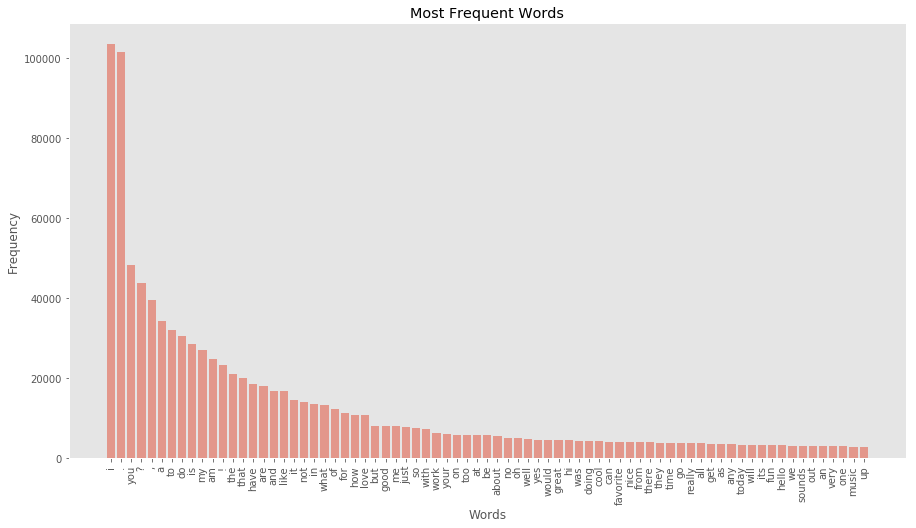

In [8]:
plot_bar_tuples(sorted_word_dictionary[0:75], "Most Frequent Words", "Words", "Frequency")

<b>Figure In another bar plot, show the 75 least frequent words (x-axis) and their number of occurences (y-axis). [1 pt] </b>

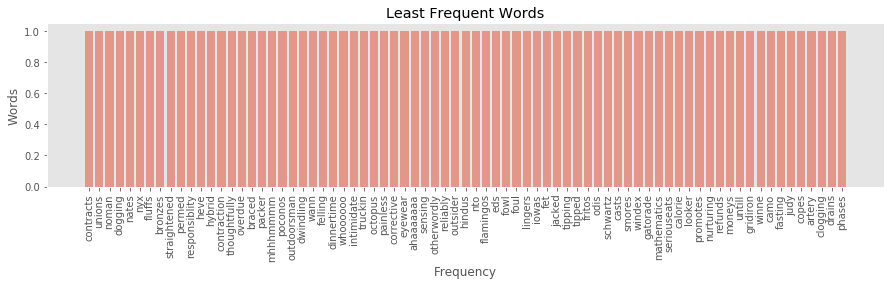

In [9]:
plot_bar_tuples(sorted_word_dictionary[-75:], "Least Frequent Words", "Frequency", "Words", (15,3))

<b>Figure In a log-log scale, plot the sorted word index (x-axis) vs their respective count (y-axis). [1 pt]</b>

In [10]:
def plot_log_log(data, title, x_label, y_label):
    """
    Plot data on log-log axis
    
    :param data:      data to be plotted
    :param title:     title of the figure
    :param x_label:   label of the x-axis
    :param y_label:   label of the y-axis
    """
    fig, ax = plt.subplots(figsize=(15, 5))
    fig.suptitle(title)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.set_ylim(1, max(data))
    ax.set_xlim(1, max(data))
    plt.gca().set_aspect('equal', adjustable='box')
    ax.plot(data)

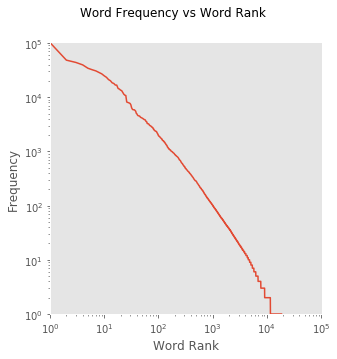

In [11]:
plot_log_log([word_count[1] for word_count in sorted_word_dictionary],
             "Word Frequency vs Word Rank", "Word Rank", "Frequency")

<b>Question How many words appear only once in the entire dataset? [1 pt]</b>

In [12]:
# number of words with count one
words_count_one = [word_count[0] for word_count in word_dictionary.items() if word_count[1] == 1]

In [13]:
count_one_nb   = len(words_count_one)
count_one_perc = len(words_count_one) * 100.0 / len(word_dictionary)
print("Number of words that occur only once: %d (%0.2f%% of the whole vocabulary)"%(count_one_nb, count_one_perc))

Number of words that occur only once: 7080 (37.92% of the whole vocabulary)


### Filtering

We suggest to filter your data by removing sentences containing rare words. 


**Code** To achieve that, you should create a new dataset where sentences containing rare words (words that occur less than N times in the dataset) are removed. Keep at least 50'000 sentences (depending on your computing power, you can keep more). 
HINT: Start by updating the dictionary accordingly and then remove any sentence that contains at least a single word that is not in the dictionary of words. [2 pts]

**Question**: How much did you reduce the number of unique words with your rare event suppression procedure? [1 pt]
    
**Answer**: Removed 11807 words from total of 18673 words.

**Question**: How many sentences are in your filtered and original dataset? [1 pt]

**Answer**: 114615 sentences in filtered and 131424 sentences in an old dataset.

**Question**: What is the impact on learning and generalization of removing sentences with rare words from your dataset? [2 pt]

**Answer**:  ToDo run with and without and explain results with some theoretical knowledge. Draft: in case of next word prediction, you can not predict a word that is not in a dictionary

<b>Code To achieve that, you should create a new dataset where sentences containing rare words (words that occur less than N times in the dataset) are removed. Keep at least 50'000 sentences (depending on your computing power, you can keep more). HINT: Start by updating the dictionary accordingly and then remove any sentence that contains at least a single word that is not in the dictionary of words. [2 pts]</b>

In [14]:
threshold=10
filtered_dict = {k:v for k,v in word_dictionary.items() if v >= threshold}
rare_words = {k for k,v in word_dictionary.items() if v < threshold}
print("Removed %d words from total of %d words"%(len(rare_words), len(word_dictionary)))

Removed 13881 words from total of 18673 words


In [15]:
def contains_rare_word(sentence, rare_words):
    """
    Checks if sentence contains any of the rare words
    :param sentence:   Sentence to be checked
    :param rare_words: List of the rare words
    
    :return:           Whether sentence contains any of the rare words
    """
    for word in sentence:
        if word in rare_words:
            return True
    return False

def filter_dataset(conversations, rare_words):
    """ 
    Returns filtered dataset containing sentences in which rare words do not accur
    
    :conversations: conversations dataset
    :rare_words:    list of rare words
    
    :return:        filtered dataset
    """
    
    filtered_dataset = []
    old_sentence_nb  = 0
    filt_sentence_nb = 0
    
    for conversation in conversations:
        filtered_conversation = []
        for sentence in conversation:
            split_sentence = sentence.split(" ")
            
            if (not contains_rare_word(split_sentence, rare_words)):
                filtered_conversation.append(split_sentence)
        
        if filtered_conversation: # If it is not empty
            filtered_dataset.append(filtered_conversation)
            
        old_sentence_nb  += len(conversation)
        filt_sentence_nb += len(filtered_conversation)
        
    print("Filtered %d out of %d sentences"%(old_sentence_nb-filt_sentence_nb, old_sentence_nb))
    print("%d sentences in filtered and %d sentences in an old dataset."%(filt_sentence_nb, old_sentence_nb))

    return filtered_dataset

In [16]:
filtered_conversations = filter_dataset(conversations, rare_words)

Filtered 26936 out of 131424 sentences
104488 sentences in filtered and 131424 sentences in an old dataset.


### Tokenization and padding

Now you will transform our filtered data into a format that is understandable by an ANN. To achieve that, you should transform words to integers, where single integers in the range [1,size of the dictionary] are mapped to single words in your dictionary. This process is commonly named 'tokenization'. In addition, we will keep the value 0 to a specific artificial word 'PADD' that will be used to account for the variable length of sentences and add to each sentence a 'START' and an 'END' word. 

**Code** Start by adding the three artificial words to your dictionary (list of possible tokens) and then translate every sentences to a list of integers. 
HINT: use the Python List index() method. [2 pts]

**Figure** Use the violinplot to show the density of tokenized sentences length. [1pt]

**Code** From this figure, select a maximum number (=maxlen) of tokens for which most of the sentences have less. Padd (and eventually truncate) all sentences with the 'PADD' token (value 0 in the integer representation) until all tokenized sentences have the same length (maxlen).
HINT: use the pad_sequences function from keras.preprocessing.sequence [2 pts]

**Code** Check that you can recover the original sentence. Randomly select two sentences from your integer and padded representation and translate them back using your dictionary. [1 pt]

<b>Code Start by adding the three artificial words to your dictionary (list of possible tokens) and then translate every sentences to a list of integers. HINT: use the Python List index() method. [2 pts]</b>

In [17]:
def create_dict_mapping(dictionary):
    """
    Creates an array from dictionary where index of an token is its mapping
    
    :param dictionary: dictionary to be mapped
    
    :return: mapping of the dictionary
    """
    dict_mapping = ['PADD']
    dict_mapping += list(dictionary)
    dict_mapping.append('START')
    dict_mapping.append('END')
    
    return dict_mapping
    
dict_mapping = create_dict_mapping(filtered_dict)

In [18]:
def map_conversations(conversations, dict_mapping):
    """
    Maps words/tokens of conversation to its corresponding integers
    
    :param conversations:   conversation to be mapped
    :param dict_mapping:    mapping of tokens defined by their index
    
    :return: mapped conversation
    """
    
    mapped_conversations = []
    
    for conversation in conversations:
        mapped_conversation = []
        for sentence in conversation:
            mapped_sentence = [dict_mapping.index('START')]
            for word in sentence:
                mapped_sentence.append(dict_mapping.index(word))
            mapped_sentence.append(dict_mapping.index('END'))
            mapped_conversation.append(mapped_sentence)
        mapped_conversations.append(mapped_conversation)
    return mapped_conversations

mapped_conversations = map_conversations(filtered_conversations, dict_mapping)

<b>Figure: Use the violinplot to show the density of tokenized sentences length. [1pt]</b>

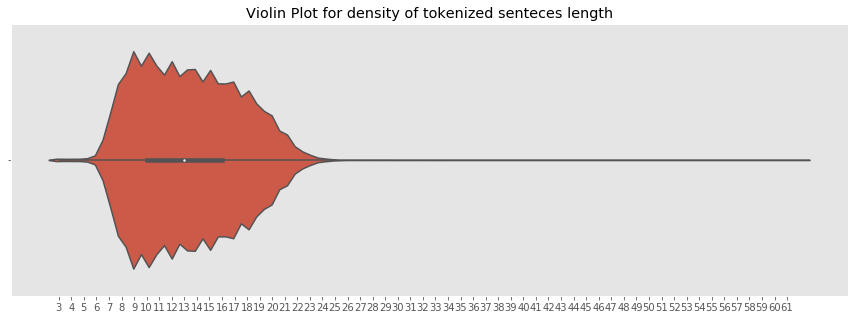

In [19]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(15, 5))
#plt.figure(figsize=(15, 5))
plt.title("Violin Plot for density of tokenized senteces length")
sentence_length = [len(sentence) for conversation in mapped_conversations for sentence in conversation]
sns.violinplot(x=sentence_length)
start, end = (min(sentence_length), max(sentence_length))
ax.xaxis.set_ticks(np.arange(start, end, 1))
plt.show()

<b> Code: From this figure, select a maximum number (=maxlen) of tokens for which most of the sentences have less. Padd (and eventually truncate) all sentences with the 'PADD' token (value 0 in the integer representation) until all tokenized sentences have the same length (maxlen). HINT: use the pad_sequences function from keras.preprocessing.sequence [2 pts] </b>

In [20]:
def standardize_conversations(conversations, max_tokens):
    """
    Standardizes conversations so that each sentence has max_tokens tokens either padding or truncating
    
    :param conversations: conversations to be standardized
    :param max_tokens:    number of tokens per sentence
    
    :return:              standardized conversations
    """
    stand_convs = []
    
    for conversation in conversations:
        stand_convs.append(pad_sequences(conversation, maxlen=max_tokens, padding='post', truncating='post'))    
    return stand_convs

In [21]:
#ToDo ask the TAs about this 
max_tokens = 25

In [22]:
stand_convs = standardize_conversations(mapped_conversations, max_tokens)

<b> Code Check that you can recover the original sentence. Randomly select two sentences from your integer and padded representation and translate them back using your dictionary. [1 pt] </b>

In [23]:
def recover_sentence(sentence, mapped_dict):
    # remove padding
    unpadded_sentence = [index for index in sentence if index != dict_mapping.index('PADD')]
    # map integers back to words
    word_sentence = [mapped_dict[index] for index in unpadded_sentence]
    # remove start and end
    return word_sentence[1:-1]

In [24]:
# original sentences 
sentences = [sentence for conversation in filtered_conversations for sentence in conversation]
# standardizes sentences with tokenization, padding and length standardization
std_sentences = np.array([sentence for conversation in stand_convs for sentence in conversation])

In [25]:
# reconstruct two random sentences
for i in range(2):
    index = randint(0, len(sentences))
    print("Original Sentence: %s"%sentences[index])
    print("Standardized Sentence: %s"%std_sentences[index])
    print("Reconstructed Sentence: %s \n"%recover_sentence(std_sentences[index], dict_mapping))

Original Sentence: ['that', 'is', 'one', 'of', 'my', 'favorite', 'colors', 'along', 'with', 'red', '.']
Standardized Sentence: [4793   45   25   26   27   28   29  556  177   92  996   19 4794    0
    0    0    0    0    0    0    0    0    0    0    0]
Reconstructed Sentence: ['that', 'is', 'one', 'of', 'my', 'favorite', 'colors', 'along', 'with', 'red', '.'] 

Original Sentence: ['that', 'good', 'i', 'hope', 'you', 'enjoy', 'it']
Standardized Sentence: [4793   45  102    8  356    5  137  166 4794    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]
Reconstructed Sentence: ['that', 'good', 'i', 'hope', 'you', 'enjoy', 'it'] 



### Saving

Now is a good time to save your data (end of processing). An example code using the pickle library is shown below.


In [31]:
import pickle

def save_data():    
    #save
    with open("data.pkl", "wb") as file:
        pickle.dump([filtered_conversations, filtered_dict, dict_mapping, std_sentences], file)

def load_data():
    #load
    with open("data.pkl", "rb") as file:
         return pickle.load(file)
        
#save_data()

[filtered_conversations, filtered_dict, dict_mapping, std_sentences] = load_data()

## Building and training generative models of language

### RNN vs LSTM vs GRU 

Build, train and compare generative models of language based on RNNs with different recurrent units (SimpleRNN, GRU and LSTM). 

The target of the network will be to approximate the word transition probabilities Pr(word[n+1]|H[n]) with H[n]=f(word[:n]) being the hidden state of the network.  

**code** You should complete the proposed model (using the Keras API rather than the Sequential model for more flexibility). Be sure to understand each line. The embedding layer allows to transform an integer to a dense vector. That would be our input to the recurrent network - each sentence is mapped to a sequence of vectors, each representing a single word. You can then design your own readout(s) and output layers. By default, use the proposed meta parameters. You can adapt them if you have more or less computing power (32 epochs should take around 30 minutes). [2 pts]

**Question** How will your networks deal with the artificial word 'PADD' that you added at the end of each sentences  [2 pts]

**Answer** We include a mask layer after the embedding layer (using argument mask_zero=True in Embedding keras layer) treating 'PADD' (integer 0) input as end of the sequence. This allows RNN to process sequences of arbitary length from 1 to max_token and discard padded inputs.

**code** Then train three different networks with the same architecture but using different recurrent units (simpleRNN, GRU and LSTM). Save the learning history (training/validation loss and accuracy for each epoch) as well as the models. [1 pt]

**Question** How can you use this network to approximate the word transition probabilities? What will be the inputs and targets of the network at each batch? Give the input/output tensor dimensions. [2 pts]

**Answer** This network is modelled to predict next word given the "history" (function of) previous  $n$ words in the sentence. Thus, we can treat the softmax output of the neural network as conditional probability distribution of $(n+1)^{th}$ word given the history of past $n$ words (i.e. transition probability of next word, given the history of the past words).

For each batch, the inputs are the integer word sequences and targets are the same word sequences but with one step delayed. Thus, the neural network learns to predict next word in the sentence given previous words.

Input tensor dimension: [batch_size, max_time_step -1, 1]  
Output tensor dimension: [batch_size, max_time_step -1, 1]  
Where max_time_step is the length of a given sentence.

**Figure** Show the learning curves (training and validation loss) for the different recurrent units. [1 pt]

**Figure** Show the learning curves (training and validation accuracy) for the different recurrent units. [1 pt]

**Question:** Which recurrent unit yields the best validation accuracy? Which is the fastest learner? [1 pt]

**Answer**: The fastest learning is RNN because it has the fewest parameters. Best validation accuracy is achived by ????

**Question:** Do you observe an overfitting effect? Where and for which case? Give a possible explanation. [1 pt] 

**Answer**: Yes, we observe overfitting for all cases (RNN, LSTM, GRU). One of the explanations could be that some of the classes (words) occur just a few times (uneven distribution of classes) in the training set, which makes it hard for the network to generalize. It could also be memorizing some of the sentences because of the above mentioned reason. Therefore, lack of data (especially minority classes) could be one of the possible explanation.

**Question:** Suggest one option modifying your dataset to decrease overfitting. [1 pt]

**Answer**: One option would be to have a higher threshold (smaller vocablary size) that would lead to sentences words of which accure quite often. In terms of classification, there would be many examples of each class. Therefore, network will easily learn to generalize and overfitting would be less likely to accur.

**Question:** Suggest one possible option modifying your network to decrease overfitting. [1 pt]

**Answer**: Reducing complexity of network or introducing dropouts would decrease overfitting (having less parameters to learn).

**Question:** Suggest one possible option modifying the training modalities to counter overfitting. [1 pt]   

**Answer**: Early stopping could be used to counter overfitting or teacher forcing?

<b>code You should complete the proposed model (using the Keras API rather than the Sequential model for more flexibility). Be sure to understand each line. The embedding layer allows to transform an integer to a dense vector. That would be our input to the recurrent network - each sentence is mapped to a sequence of vectors, each representing a single word. You can then design your own readout(s) and output layers. By default, use the proposed meta parameters. You can adapt them if you have more or less computing power (32 epochs should take around 30 minutes). [2 pts]</b>

In [32]:
nb_tokens = len(dict_mapping)
print("Size of dictionary: %d"%nb_tokens)

Size of dictionary: 4795


In [33]:
#Meta-parameters
embedding_size = 128
hidden_size = 64
dropout = 0.
recurrent_dropout = 0.

batch_size = 64
epochs = 32
validation_split = 0.2

dataset_cut = -1

In [34]:
# input layers
I = {}
# embedding layers
E = {}
# hidden layers
H = {}
# readout
R = {}
# output 
Y = {}
models = {}
logs = {}

In [35]:
X = std_sentences
# convert output to shape [batch_size, max_step, feature_size]
T = std_sentences.reshape((std_sentences.shape[0], std_sentences.shape[1], 1))

In [77]:
def append_run_language_model(nb_tokens,
                              input_len,
                              embedding_size,
                              hidden_size,
                              n_hidden_layers,
                              I, E, H, R, Y,
                              models,
                              logs,
                              X, T,
                              dropout=0.0,
                              recurrent_dropout=0.0,
                              early_stopping=False,
                              embedding_weights=None,
                              model_type='RNN',
                              model_name=''):
    """
    Appends models to the dictionary
    
    :param nb_tokens:             vocabulary size
    :param input_len:             lenght of input sentences
    :param embedding_size:        dimension of word embeddings
    :param hidden_size:           output size of RNN/ neurons in recurrent hidden layers
    :param n_hidden_layers:       number of recurrent hidden layers
    :param I, E, H, R, Y:         dictionaries poiting to the model layers
    :param models:                dictionary to append the trained model
    :param logs:                  dictionary to store logs (train/val history)
    :param x:                     input
    :param T:                     target
    :param dropout:               dropout probability in non recurrent layers
    :param recurrent_dropout:     dropout probability in the recurrent layers
    :param early_stopping:        Whether to use the early stopping technique
    :param embedding_weights:     list of embeddings, otherwise embedding is learnt in this function
    :param model_type:            type of a model, 'RNN' by default
    :param model_name:            name of the model, final name will be model_type model_name
    """
    
    model_name = model_type + model_name
    
    # create an input layer
    I[model_name] = Input(shape=(input_len-1,), name="input")
    
    # if word embeddings are not given, create them otherwise create Embedding of the given weights
    if embedding_weights is None:
        E[model_name] = Embedding(nb_tokens,         # size of the vocabulary
                                  embedding_size,    # dimension of word embedding
                                  mask_zero=True,    # specify we have padding represented as 0s
                                  name="embedding",
                                  input_length=input_len-1)(I[model_name]) # we pass the output of prev layer to the input
    else:
        E[model_name] = Embedding(nb_tokens,
                                  embedding_size,
                                  mask_zero=True,
                                  weights=embedding_weights,
                                  name="embedding",
                                  input_length=input_len-1,
                                  trainable=True)(I[model_name])
    if model_type == 'RNN':
        rnn_cell = SimpleRNN
    elif model_type == 'GRU':
        rnn_cell = GRU
    elif model_type == 'LSTM':
        rnn_cell = LSTM
    else:
        raise Exception('model type is not defined')
    
    # output of the last layer
    out = E[model_name]
    
    #create hidden recurrent layers
    for _ in range(n_hidden_layers):
        out = rnn_cell(hidden_size,
                       dropout=dropout,
                       recurrent_dropout=recurrent_dropout,
                       return_sequences=True)(out)  # whether to return the last state in addition to the output
    
    H[model_name] = out
    
    # We use timedistributed to convert the output of pervious layer of shape [batch_size]
    R[model_name] = TimeDistributed(Dense(embedding_size, activation='relu'), name='readout')(H[model_name])
    R[model_name] = TimeDistributed(Dropout(dropout))(R[model_name])
    Y[model_name] = TimeDistributed(Dense(nb_tokens, activation='softmax'), name='output')(R[model_name])

    models[model_name] = Model(inputs = [I[model_name]], outputs = [Y[model_name]])
    
    models[model_name].compile(
        loss='sparse_categorical_crossentropy', # we needed to update keras since this function produces bug on latest version
        optimizer=Adam(),
        metrics=['acc'])
    models[model_name].summary()
    
    print(X[:,:-1].shape, T[:,1:].shape)
    
    cb = [EarlyStopping(monitor='val_acc', min_delta=0.001, patience=2)] if early_stopping else []
    
    # ToDo why are we doing :dataset_cut??? ToDo remove dataset_cut
    logs[model_name] = models[model_name].fit({'input': X[:,:-1]}, {'output': T[:,1:]}, 
                                              epochs=epochs,
                                              validation_split=validation_split,
                                              batch_size=batch_size,
                                              callbacks=cb).history

    #save logs
    with open(model_type+"model_"+str(embedding_size)+'_'+str(hidden_size)+'_'+str(n_hidden_layers)+"_log.pkl", "wb") as file:
        pickle.dump(logs[model_name], file)
        
    #save model
    models[model_name].save(model_type+"model_"+str(embedding_size)+'_'+str(hidden_size)+'_'+str(n_hidden_layers))

<b>code Then train three different networks with the same architecture but using different recurrent units (simpleRNN, GRU and LSTM). Save the learning history (training/validation loss and accuracy for each epoch) as well as the models. [1 pt] </b>

In [37]:
# Simple rnn model
append_run_language_model(nb_tokens,
                          max_tokens,
                          embedding_size,
                          hidden_size,
                          1,
                          I, E, H, R, Y,
                          models,
                          logs,
                          X, T,
                          dropout=0.5,
                          recurrent_dropout=0.5,
                          model_type='RNN')

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 24)                0         
_________________________________________________________________
embedding (Embedding)        (None, 24, 128)           613760    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 24, 64)            12352     
_________________________________________________________________
readout (TimeDistributed)    (None, 24, 128)           8320      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 24, 128)           0         
_________________________________________________________________
output (TimeDistributed)     (None, 24, 4795)          618555    
Total params: 1,252,987
Trainable params: 1,252,987
Non-trainable params: 0
_________________________________________________

In [38]:
def load_model_logs(model_path):
    #load RNN Model
    with open(model_path, "rb") as file:
        RNNmodel_log = pickle.load(file)
    return RNNmodel_log

In [39]:
#GRU model
append_run_language_model(nb_tokens,
                          max_tokens,
                          embedding_size,
                          hidden_size,
                          1,
                          I, E, H, R, Y,
                          models,
                          logs,
                          X, T,
                          dropout=0.5,
                          recurrent_dropout=0.5,
                          model_type='GRU')

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 24)                0         
_________________________________________________________________
embedding (Embedding)        (None, 24, 128)           613760    
_________________________________________________________________
gru_1 (GRU)                  (None, 24, 64)            37056     
_________________________________________________________________
readout (TimeDistributed)    (None, 24, 128)           8320      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 24, 128)           0         
_________________________________________________________________
output (TimeDistributed)     (None, 24, 4795)          618555    
Total params: 1,277,691
Trainable params: 1,277,691
Non-trainable params: 0
_________________________________________________

In [ ]:
#LSTM model
append_run_language_model(nb_tokens,
                          max_tokens,
                          embedding_size,
                          hidden_size,
                          1,
                          I, E, H, R, Y,
                          models,
                          logs,
                          X, T,
                          dropout=0.5,
                          recurrent_dropout=0.5,
                          model_type='LSTM')

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 24)                0         
_________________________________________________________________
embedding (Embedding)        (None, 24, 128)           613760    
_________________________________________________________________
lstm_1 (LSTM)                (None, 24, 64)            49408     
_________________________________________________________________
readout (TimeDistributed)    (None, 24, 128)           8320      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 24, 128)           0         
_________________________________________________________________
output (TimeDistributed)     (None, 24, 4795)          618555    
Total params: 1,290,043
Trainable params: 1,290,043
Non-trainable params: 0
_________________________________________________

<b>Figure Show the learning curves (training and validation loss) for the different recurrent units. [1 pt] </b>

<b>Figure Show the learning curves (training and validation accuracy) for the different recurrent units. [1 pt] </b>

In [48]:
# read saved logs
RRN_logs  = load_model_logs("RNNmodel_128_64_1_log.pkl")
GRU_logs  = load_model_logs("GRUmodel_128_64_1_log.pkl")
LSTM_logs = load_model_logs("LSTMmodel_128_64_1_log.pkl")

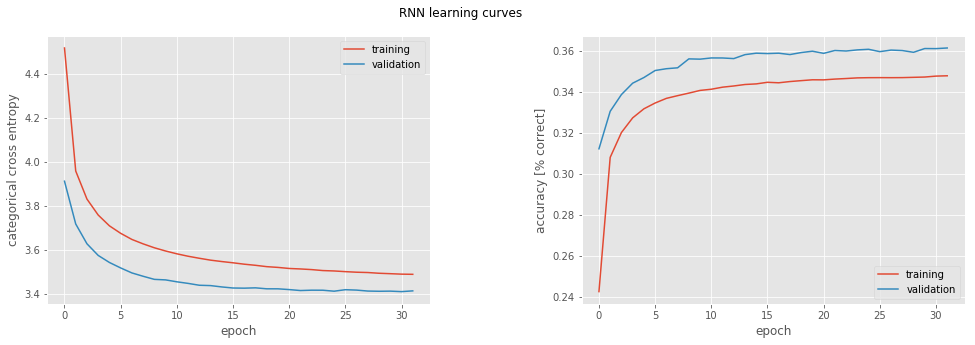

In [49]:
fig_RNN = plot_history(RRN_logs, "RNN learning curves")

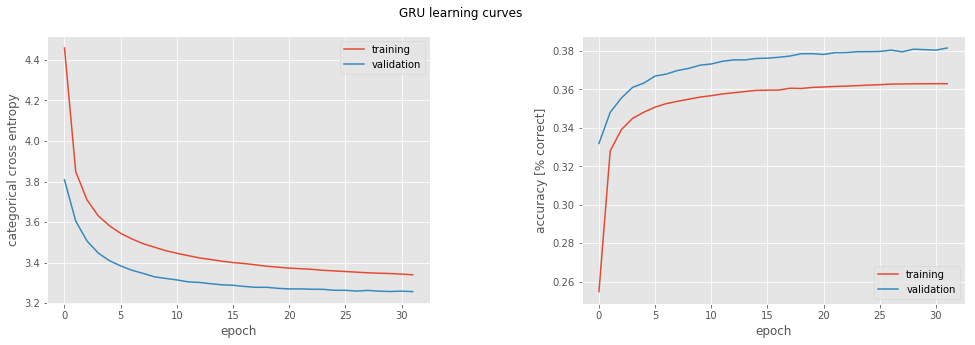

In [50]:
fig_GRU = plot_history(GRU_logs, "GRU learning curves")

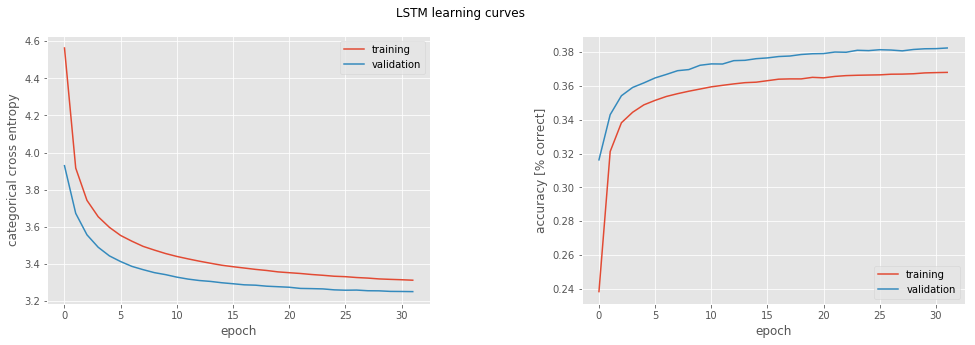

In [51]:
fig_LSTM = plot_history(LSTM_logs, "LSTM learning curves")

TODO: Plot learning curves without dropouts

### Optimal network size

Compare the learning curves for three networks with 64 (previous exercise), 128 and 256 GRUs (single layer) and one with two hidden layers of 64 GRUs. 

**Code** Build and train the networks. Apply EarlyStopping (monitor='val_acc', min_delta=0.001, patience=2). Use transfer learning, do not train from scratch your embedding layer, rather re-use the embedding layer from your best performing network in the last exercise. [4 pts]

**Figure** Show the learning curves (training and validation loss) for the four models. [1 pt]

**Figure** Show the learning curves (training and validation accuracy) for the four models. [1 pt]

**Question** List and briefly explain the differences in the learning curves for the different models? [2 pts]

**Answer**   

**Question** What effect had EarlyStopping? Give one advantage and one drawback. [2 pts]

**Answer**

**Question** What is your best model? Why? [1 pt]

**Answer**


In [75]:
I_GRU = {}
E_GRU = {}
H_GRU = {}
R_GRU = {}
Y_GRU = {}
# Get weigths of the embedding layer of pretrained model
embeddings_pre_trained = models['GRU'].layers[1].get_weights()

In [76]:
append_run_language_model(nb_tokens,
                          max_tokens,
                          embedding_size,
                          128,
                          1,
                          I_GRU, E_GRU, H_GRU , R_GRU, Y_GRU,
                          models,
                          logs,
                          X, T,
                          dropout=0.5,
                          recurrent_dropout=0.5,
                          early_stopping=True,
                          embedding_weights=embeddings_pre_trained,
                          model_type='GRU',
                          model_name='128')

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 24)                0         
_________________________________________________________________
embedding (Embedding)        (None, 24, 128)           613760    
_________________________________________________________________
gru_12 (GRU)                 (None, 24, 128)           98688     
_________________________________________________________________
readout (TimeDistributed)    (None, 24, 128)           16512     
_________________________________________________________________
time_distributed_11 (TimeDis (None, 24, 128)           0         
_________________________________________________________________
output (TimeDistributed)     (None, 24, 4795)          618555    
Total params: 1,347,515
Trainable params: 1,347,515
Non-trainable params: 0
________________________________________________

In [79]:
append_run_language_model(nb_tokens,
                          max_tokens,
                          embedding_size,
                          256,
                          1,
                          I_GRU, E_GRU, H_GRU , R_GRU, Y_GRU,
                          models,
                          logs,
                          X, T,
                          dropout=0.5,
                          recurrent_dropout=0.5,
                          early_stopping=True,
                          embedding_weights=embeddings_pre_trained,
                          model_type='GRU',
                          model_name='256')

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 24)                0         
_________________________________________________________________
embedding (Embedding)        (None, 24, 128)           613760    
_________________________________________________________________
gru_15 (GRU)                 (None, 24, 256)           295680    
_________________________________________________________________
readout (TimeDistributed)    (None, 24, 128)           32896     
_________________________________________________________________
time_distributed_13 (TimeDis (None, 24, 128)           0         
_________________________________________________________________
output (TimeDistributed)     (None, 24, 4795)          618555    
Total params: 1,560,891
Trainable params: 1,560,891
Non-trainable params: 0
________________________________________________

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [78]:
append_run_language_model(nb_tokens,
                          max_tokens,
                          embedding_size,
                          64,
                          2,
                          I_GRU, E_GRU, H_GRU , R_GRU, Y_GRU,
                          models,
                          logs,
                          X, T,
                          dropout=0.5,
                          recurrent_dropout=0.5,
                          early_stopping=True,
                          embedding_weights=embeddings_pre_trained,
                          model_type='GRU',
                          model_name='64_2')

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 24)                0         
_________________________________________________________________
embedding (Embedding)        (None, 24, 128)           613760    
_________________________________________________________________
gru_13 (GRU)                 (None, 24, 64)            37056     
_________________________________________________________________
gru_14 (GRU)                 (None, 24, 64)            24768     
_________________________________________________________________
readout (TimeDistributed)    (None, 24, 128)           8320      
_________________________________________________________________
time_distributed_12 (TimeDis (None, 24, 128)           0         
_________________________________________________________________
output (TimeDistributed)     (None, 24, 4795)          618

<b>Figure Show the learning curves (training and validation loss) for the four models. [1 pt] </b>

<b>Figure Show the learning curves (training and validation accuracy) for the four models. [1 pt]</b>

In [80]:
GRU_64_1_logs    = load_model_logs("GRUmodel_128_64_1_log.pkl")
GRU_128_1_logs   = load_model_logs("GRUmodel_128_128_1_log.pkl")
GRU_256_1_logs   = load_model_logs("GRUmodel_128_256_1_log.pkl")
GRU_64_2_logs    = load_model_logs("GRUmodel_128_64_2_log.pkl")

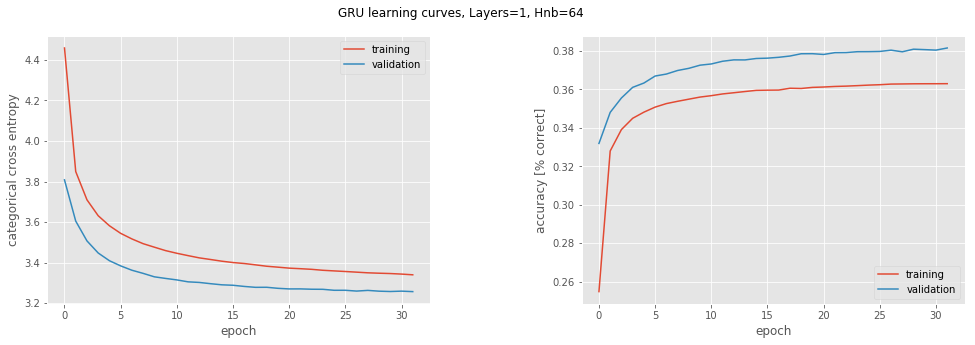

In [81]:
fig_GRU_64_1_logs = plot_history(GRU_64_1_logs, "GRU learning curves, Layers=1, Hnb=64")

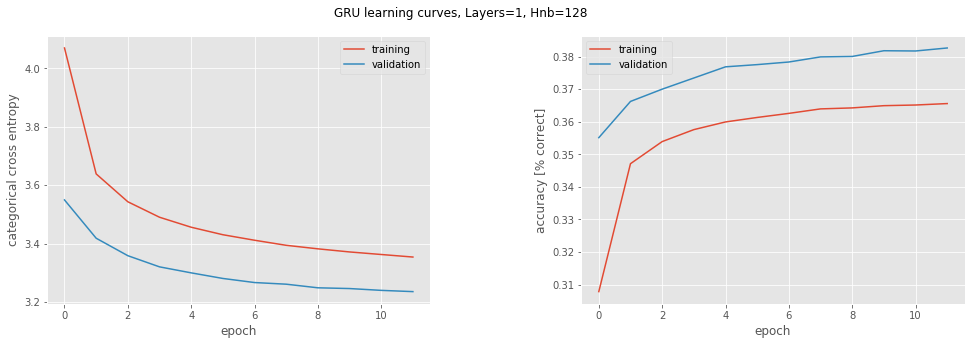

In [82]:
fig_GRU_128_1_logs = plot_history(GRU_128_1_logs, "GRU learning curves, Layers=1, Hnb=128")

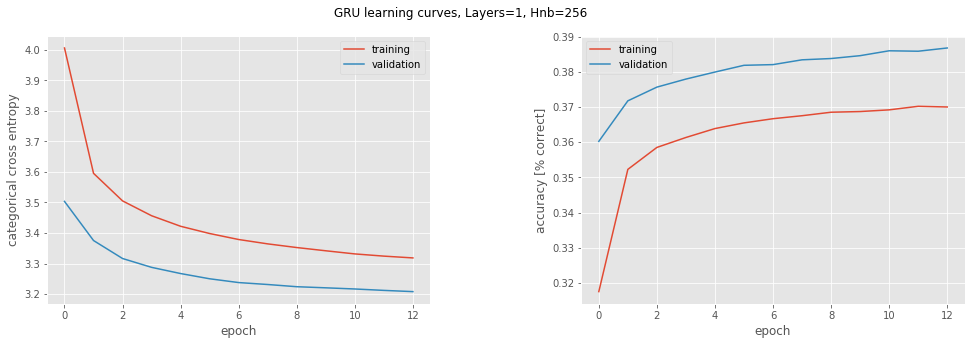

In [83]:
fig_GRU_256_1_logs = plot_history(GRU_256_1_logs, "GRU learning curves, Layers=1, Hnb=256")

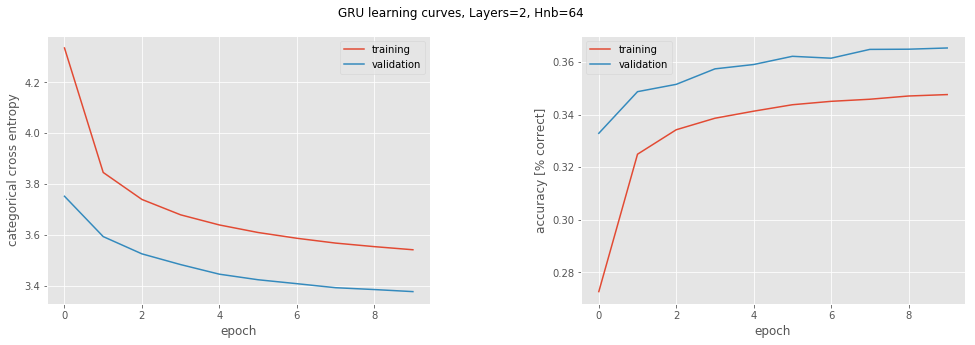

In [84]:
fig_GRU_64_2_logs = plot_history(GRU_64_2_logs, "GRU learning curves, Layers=2, Hnb=64")

### Generate sentences

Now you will generate new sentences from your best performing model.

**Code** To achieve that, use the provided sample function below to generate new sentences from your model. You should start by constructing a sentence that starts with the 'START' artificial word and all other words being the 'PADD' artificial word. Then sample the first word from the corresponding probabilities given by your model. Add this word to the sentence and continue like this until you sample the 'END' artificial word or the maximum sentence length. [2 pts]

**Code** Generate 10 sentences for different sampling temperature in [0., 0.25, 0.5, 0.75, 1., 1.5., 2.]. [1 pt]

**7 Figures** For each temperature, use matplotlib imshow to plot the probablities of every word in one generated sentence (and only these words) at each time step. y-axis should be the words that are present in the sentence. x-axis the timesteps and the imshow value the probabilities given by the model for all words in the sentence at each timestep. Use the a colormap where 0 is white, e.g. cmap='Greys'. [2 pts]

**Code** Finally, seed your model with two different beginnings of max 4 words and let it generate 10 possible continuations (use sampling temperature of 1.). [2 pts]

**Question** What is the effect of sampling temperature on the generated sentences? [1 pt]

**Answer** Temperature modifies distribution of probabilities for the next word occurance. Temperature close to zero means that word with the highest probability is predicted. Towards one we go close to selecting next word according to the softmax distribution. The higher the temperature, the uniformer the probabilities become (very close to each other). Therefore, temperature higher than 1.5 is as good as selecting a word randomly to be the next one.

**Question** In terms of sampling a probability distribution, what does a sampling temperature of 0 corresponds to? [1 pt] 

**Answer** 0 corresponds to selecting always the word with highest probability. Meaning, that prediction becomes deterministic and outputs the same thing for the same input.

**Question** In terms of sampling a probability distribution, what does a sampling temperature of 1. corresponds to? [1 pt] 

**Answer** Sampling temperature of one corresponds to drawing samples from the same distribution as the output probabilities (softmax).

**Question** In terms of sampling a probability distribution, what does a very high sampling temperature corresponds to? [1 pt]

**Answer** Very high sampling temperature corresponding to drawing samples from approximately uniform distribution.

**Question** Based on the plotted word probabilities, explain how a sentence is generated. [2 pts]

**Answer** Sentence is generated step by step, for each of the prediction sequence predicting the next one according to their output distribution. If the predicted probability of one word is very high compared to the others, it is likely that this word gets selected. ToDO addddd some stuff whenw e recreate the plot yohooooooooo

**Question** Do you observe timesteps with more than one word with non-zero probability? How do these probable words relate in terms of language? [1 pt]

**Answer** Yes! we observe. They are mostly they same part of speech ToDO add some more stuff after recreating the plot. bring an example from the plot

<b> Code To achieve that, use the provided sample function below to generate new sentences from your model. You should start by constructing a sentence that starts with the 'START' artificial word and all other words being the 'PADD' artificial word. Then sample the first word from the corresponding probabilities given by your model. Add this word to the sentence and continue like this until you sample the 'END' artificial word or the maximum sentence length. [2 pts] </b>

In [85]:
def sample(preds, temperature=1.):
    # helper function to sample an index from a probability array
    if temperature == 0.:
        return np.argmax(preds)
    preds = np.asarray(preds).astype('float64')
    
    # smoothing, adding small value for zero probabilities
    preds = np.log(preds + 1e-8) / temperature
    
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [86]:
def generate_sentence(model, dict_mapping, max_tokens, temperature=1., sentence=[]):
    """
    Generates new sentences from model
    
    :param model:         model for predictions
    :pemperature:         temperature to be used for sampling
    :sentence:            initial sentence given, created in method if None.
                          don't add START or END symbol to initial sentence. sentence should be a list of tokens (str or mapped)
    :dict_mapping:        list of vocabulary words where index of word gives its integer representation for embedding layer.
    """
    
    # store actual predicted words
    word_sentence = sentence.copy()
    word_mapping =  []
    
    # store prediction at each sentence position
    all_preds = []
    
    # start predicting from this index
    prediction_start = len(sentence)
    
    
    # check type of sentence is empty list
    if sentence and type(sentence[0] is str):
        sentence = [dict_mapping.index(word) for word in sentence]
    
    sentence = [dict_mapping.index('START')] + sentence
    sentence = pad_sequences([sentence], maxlen=max_tokens, padding='post', truncating='post')
    
    for i in range(prediction_start, max_tokens-1):
        
        # get predictions for the current sentence
        preds = model.predict(sentence)
        
        # save predictions for words for i+1 th position
        all_preds.append(preds[0][i])
        
        # sample the word prediciton for position i+1
        next_word = sample(preds[0][i], temperature)
        
        # if the sentence end was predicted, end the process
        if(next_word == dict_mapping.index('END')):
            break
        
        # insert predicted word (integer mapping) into sentence
        sentence[0, i+1] = next_word
        
        # save an actual predicted word
        word_sentence.append(dict_mapping[next_word])
        
        # save the predicted word (its token)
        word_mapping.append(next_word)
               
    # from all predictions select predictions only for words in the sentence
    sentence_word_preds = np.array(all_preds)[:, word_mapping]
    
    return " ".join(word_sentence), sentence_word_preds

In [95]:
sen, preds = generate_sentence(models['GRU256'], max_tokens=max_tokens-1, dict_mapping=dict_mapping)
sen

'madonna , delicious after i love going outside . playing with my kids for dogs !'

<b> Code Generate 10 sentences for different sampling temperature in [0., 0.25, 0.5, 0.75, 1., 1.5., 2.]. [1 pt] </b>

In [96]:
def generate_sentences(model, max_tokens, temperatures, dict_mapping):
    """
    Generate 10 senteces according to the model for each temperature in temperatures
    """

    temp_sentences = dict()
    temp_preds = dict()
    
    for temp in temperatures:
        print("Temperature: %.2f"%temp)
        for i in range(10):
            # generate a sentece according to the model and temperature
            sentence, preds = generate_sentence(model, max_tokens=max_tokens-1, temperature=temp, dict_mapping=dict_mapping)
            print("%d) %s"%(i+1, sentence))
            
            if temp in temp_sentences:
                temp_sentences[temp].append(sentence)
                temp_preds[temp].append(preds)
            else:
                temp_sentences[temp] = [sentence]
                temp_preds[temp] = [preds]
    
    return temp_sentences, temp_preds

In [99]:
temperatures = np.arange(0, 2.1, 0.25)    
temp_sentences, temp_preds = generate_sentences(models['GRU256'], max_tokens, temperatures, dict_mapping=dict_mapping)

Temperature: 0.00
1) i am a teacher , i am a teacher .
2) i am a teacher , i am a teacher .
3) i am a teacher , i am a teacher .
4) i am a teacher , i am a teacher .
5) i am a teacher , i am a teacher .
6) i am a teacher , i am a teacher .
7) i am a teacher , i am a teacher .
8) i am a teacher , i am a teacher .
9) i am a teacher , i am a teacher .
10) i am a teacher , i am a teacher .
Temperature: 0.25
1) i am good , just got back from a new job .
2) i am a teacher . i am a nurse .
3) i am a teacher . i am a waitress .
4) i am a teacher , i am a teacher .
5) i am a good baker . i am a nurse .
6) i am a teacher , i am a teacher .
7) i am doing well , how are you ?
8) i am a nurse . i am in the midwest .
9) i am a teacher , i am a nurse .
10) i am a teacher , i am a professional artist .
Temperature: 0.50
1) i love to go to the beach .
2) i am in school . i am a lawyer .
3) i am doing good . how are you ?
4) i am a nurse . i am a nurse .
5) i am a teacher . i am a nurse .
6) i am a nurs

<b> 7 Figures For each temperature, use matplotlib imshow to plot the probablities of every word in one generated sentence (and only these words) at each time step. y-axis should be the words that are present in the sentence. x-axis the timesteps and the imshow value the probabilities given by the model for all words in the sentence at each timestep. Use the a colormap where 0 is white, e.g. cmap='Greys'. [2 pts] </b>

Temperature: 0.00, Sentence: i am a teacher , i am a teacher .


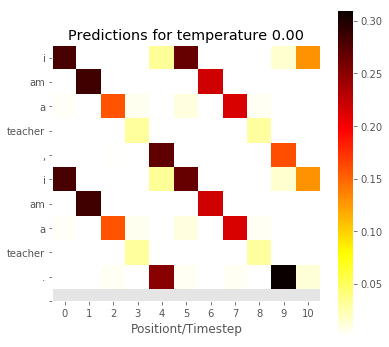

Temperature: 0.25, Sentence: i am good , just got back from a new job .


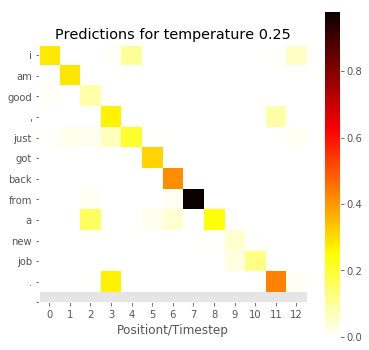

Temperature: 0.50, Sentence: i love to go to the beach .


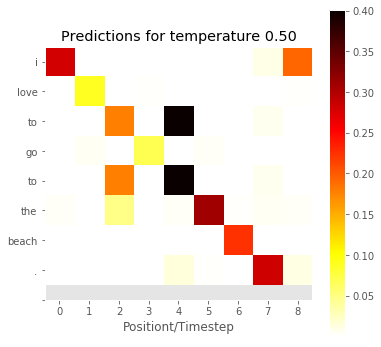

Temperature: 0.75, Sentence: i am good , just had some dogs , but i would rather be able to teach by a school in the spring


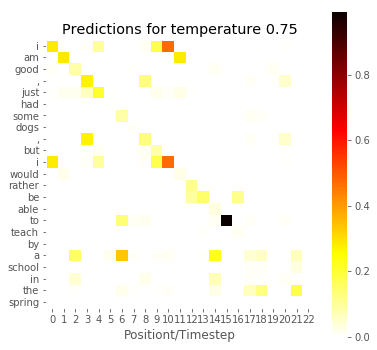

Temperature: 1.00, Sentence: where are you from ?


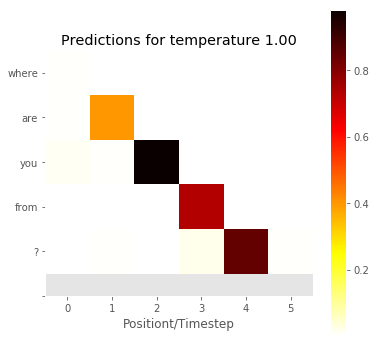

Temperature: 1.25, Sentence: i live with my 3 siblings , and do you own them ?


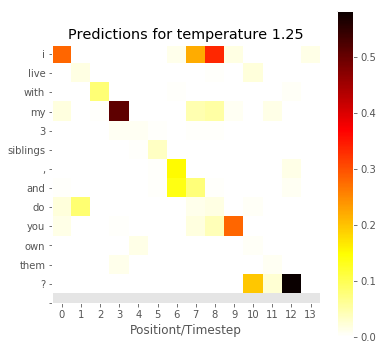

Temperature: 1.50, Sentence: outside not modern it


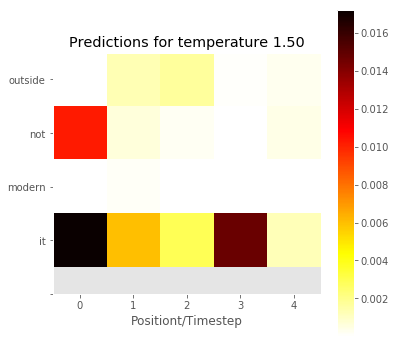

Temperature: 1.75, Sentence: very love crime films !


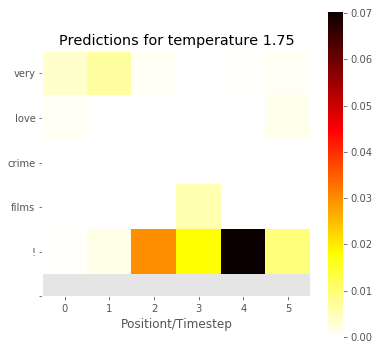

Temperature: 2.00, Sentence: all all stick with by fish advice she is the worst advise news a woman . since i hunt right because there shot


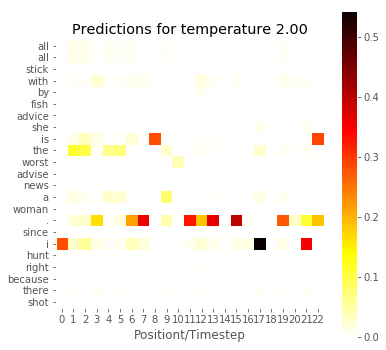

In [100]:
def plot_temp_predictions(temperatures, temp_preds, temp_sentences, sentence_nb = 1):
    
    for temp in temperatures:
        # select sentence for temperature (the first one by default)
        sentence = temp_sentences[temp][sentence_nb-1]
        # select predictions for the corresponding sentence and temp
        preds = temp_preds[temp][sentence_nb-1] #!!! prediction values of the same word might be more than once if the word
                                                # accures several times in a sentence. We did so to observe diagonal prediction!
        
        print("Temperature: %.2f, Sentence: %s"%(temp, sentence))

        
        plt.figure(figsize=(6,6))
        plt.title("Predictions for temperature %.2f"%temp)
           
        plt.imshow(np.transpose(preds), cmap='hot_r')  
        
        plt.xticks(np.arange(0, preds.shape[0]))
        plt.xlabel("Positiont/Timestep")
        
        plt.yticks(np.arange(0, preds.shape[0]), sentence.split())

        plt.colorbar()
        plt.show()
        
        #temp_preds[temp][sentence_nb-1]

plot_temp_predictions(temperatures, temp_preds, temp_sentences)


<b>Code Finally, seed your model with two different beginnings of max 4 words and let it generate 10 possible continuations (use sampling temperature of 1.). [2 pts]</b>

In [106]:
def generate_continuations(model, sentences, dict_mapping, nb_cont = 10, max_tokens=24):
    
    for sentence in sentences:
        print("Sentence: %s"%sentence)
        
        for i in range(nb_cont):
            pred_sentece, _ = generate_sentence(model,
                                                dict_mapping,
                                                max_tokens,
                                                temperature=1.0,
                                                sentence=sentence)
            print("Continuation %d) %s"%(i+1, pred_sentece))

In [107]:
my_sentence1 = ["our", "teacher", "is"]
my_sentence2 = ["i", "love"]
my_sentence3 = ["our","project", "is"]
my_sentences = [my_sentence1, my_sentence2, my_sentence3]

generate_continuations(models['GRU256'], my_sentences, dict_mapping=dict_mapping)

Sentence: ['our', 'teacher', 'is']
Continuation 1) our teacher is never been very well , i am a sucker for them
Continuation 2) our teacher is not that they travel for me for you
Continuation 3) our teacher is very artistic now . i like to do violin
Continuation 4) our teacher is not really tall
Continuation 5) our teacher is huge
Continuation 6) our teacher is really talented . i have none of the psychology of the guitar .
Continuation 7) our teacher is still first employed right now
Continuation 8) our teacher is like pregnant , they know !
Continuation 9) our teacher is this of an outgoing person . are you married ?
Continuation 10) our teacher is in cali , baseball is a good job .
Sentence: ['i', 'love']
Continuation 1) i love surfing from my grandmother . my grandma is talking that feeling .
Continuation 2) i love the beatles , i love reading the other time and lots of music ,
Continuation 3) i love my favorite video games
Continuation 4) i love to do that
Continuation 5) i love s

###  Word embedding visualization

Here, you are asked to visualize the embedding layer. 

**Code** To do that, project in 2D the embedding vectors for different words. Use t-SNE, a projection that conserve the neighborhood relationships between vectors. HINT: Build a Keras model that takes as input a list of words and outputs a list of vector embeddings as learned by your best performing model. Use t-SNE dimensionality reduction (from sklearn.manifold import TSNE). [2 pts]

**Figure** Plot the projection of the first 200 most frequent words in a 2D plot. On the plot, write the words. [2 pt] 

**Question** Do you observe clusters of words with similar meaning or role in language? Report three of them here. [1 pt]

**Answer**

**Question** Why is having similar vector representation for similar words a good approach for such models? Explain using the example clusters from before and argue in terms of prediction accuracy and/or generalization. [2 pts]

**Answer** 

In [109]:
Input_embedding = Input(shape=(1,), name="input")
embedding_layer = Embedding(nb_tokens,
                            embedding_size,
                            mask_zero=True,
                            weights=models['GRU256'].layers[1].get_weights(),
                            name="embedding",
                            input_length=None,
                            trainable=False)(Input_embedding)

word_embedding_model = Model(inputs = [Input_embedding], outputs = [embedding_layer])

In [110]:
words_int = np.arange(1, len(dict_mapping))
all_embeddings = word_embedding_model.predict(words_int)

In [111]:
all_embeddings = all_embeddings.reshape((all_embeddings.shape[0], all_embeddings.shape[2]))

In [113]:
from sklearn.manifold import TSNE
all_embeddings_TSNE = TSNE(n_components=2).fit_transform(all_embeddings)

In [115]:
most_frequent_words = [word[0] for word in sorted_word_dictionary[:200]]

In [116]:
most_frequent_words_index = [dict_mapping.index(word)-1 for word in most_frequent_words]
frequent_word_embeddings_TSNE = all_embeddings_TSNE[most_frequent_words_index]

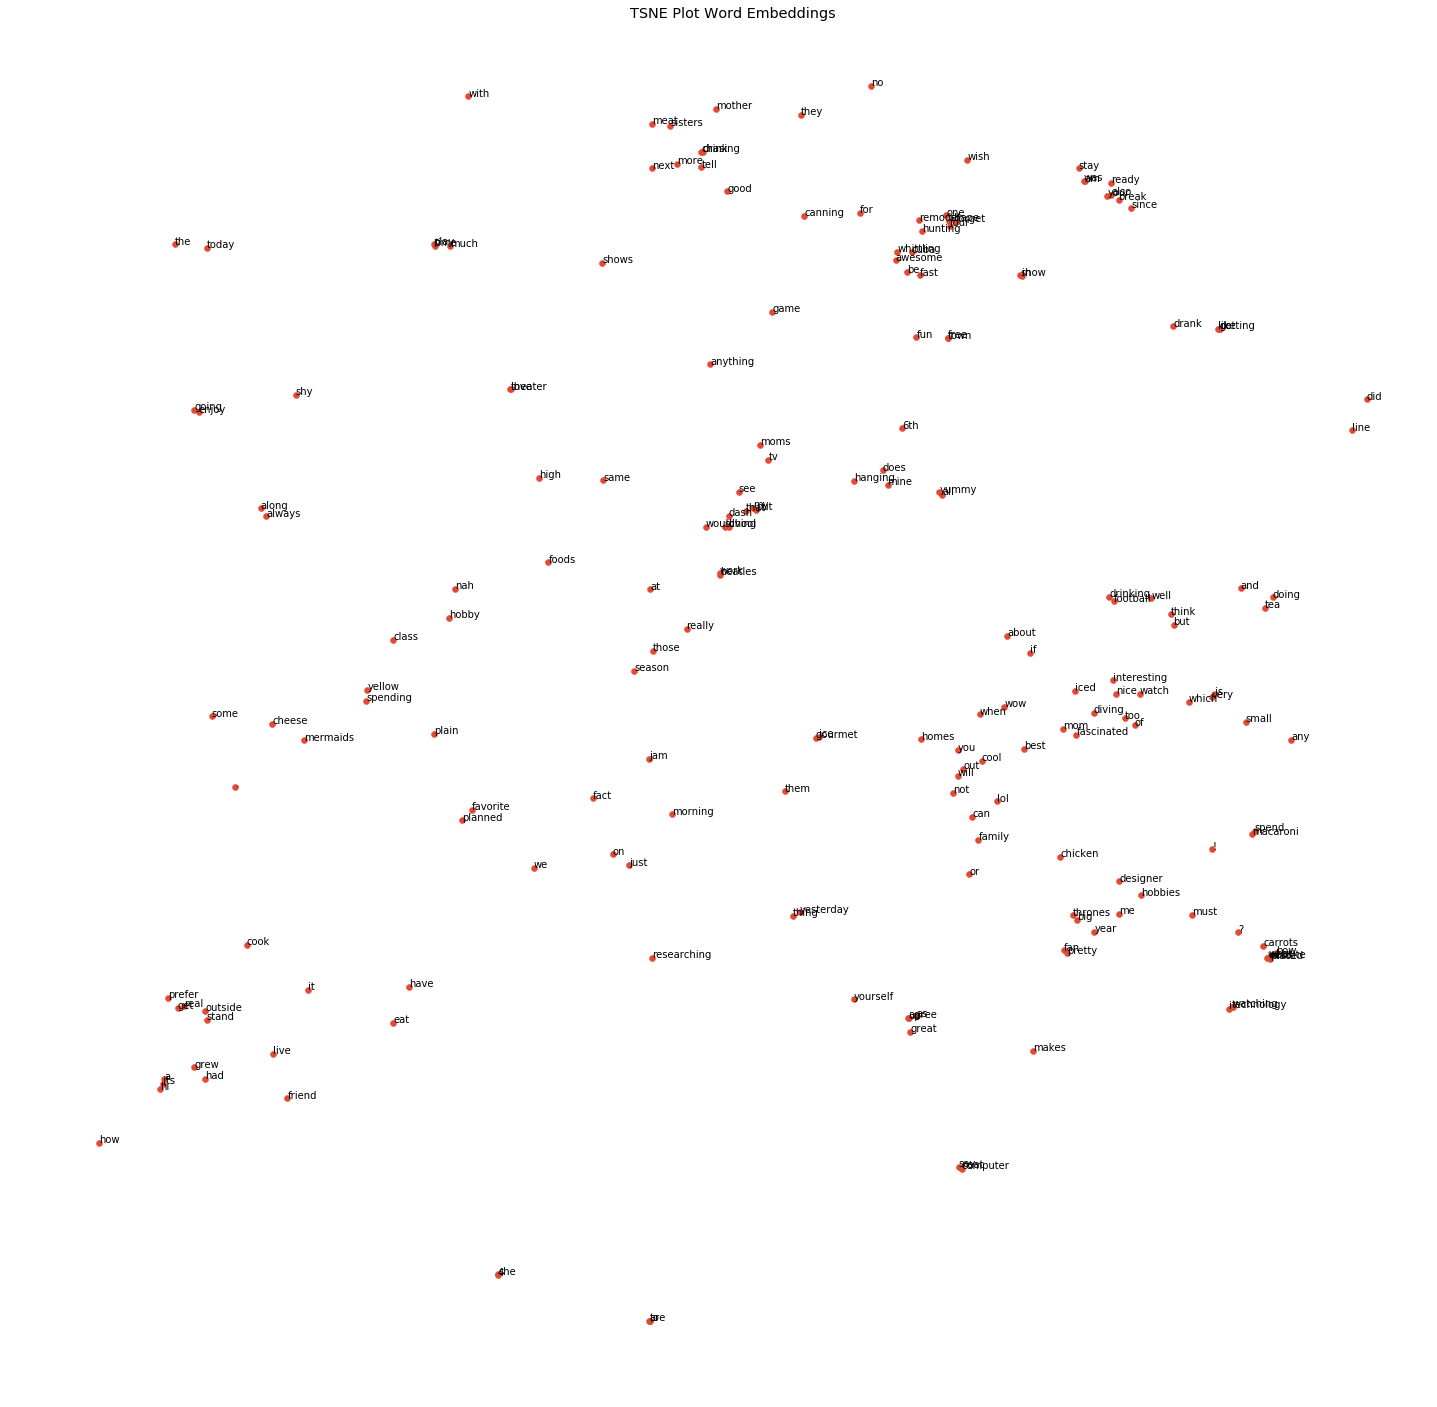

In [121]:
fig, ax = plt.subplots(figsize=(25, 25))
ax.scatter(frequent_word_embeddings_TSNE[:, 0], frequent_word_embeddings_TSNE[:, 1])
ax.set_axis_off()
ax.set_title("TSNE Plot Word Embeddings")

for i, txt in enumerate(dict_mapping[1:201]):
    ax.annotate(txt, (frequent_word_embeddings_TSNE[i, 0], frequent_word_embeddings_TSNE[i, 1]))

## Chatbot

Finally, you will construct a model with which you can chat. The network will take as input a sentence and output a response.

**Code** For that, you should go back to your original data and construct a new dataset containing pairs of sentences, where each pair is a sentence and its answer. Be careful to not include any pair of sentences that contains words not present in your filtered dictionary. [2 pts]

**Code** You should then tokenize, padd, truncate each sentence. Only the answers need the 'START' and 'END' artificial words. [1 pt]

We provide you with a possible model, you are welcome to change it. This model uses an LSTM layer to encode the first sentence (the context). The final state of this LSTM layer is transfered to initialize the state of a decoder LSTM layer from which the answer sentence will be generated. 

**Code** Train your chatbot model on your dataset. [1 pt]

**Code** Adapt your sentence generation code from before so that you can generate an answer given a context sentence from your model. [2 pts] 

**Code** After training, randomly select 10 context-answers pairs from your data and show both the real answer (the one from the data) and the generated one for two different sampling temperatures (e.g. 0.5 and 1.0). [2 pts]

**Question** How similar are the generated answers and the real ones? Does your model provide probable answers (given the dataset)? Report here one good and one bad example. [2 pts]

**Answer**

**Question** Which sampling temperature gives better answers? why? [2 pts]

**Answer**

**Question** Would it be good if your model was able to reproduce exactly each real answer? Why? [1 pt]

**Answer**

**Code** Entertain yourself with your model. Write some code to chat with your bot, let it discuss with itself, ... be creative! [2 **bonus** pts]




<b>Code For that, you should go back to your original data and construct a new dataset containing pairs of sentences, where each pair is a sentence and its answer. Be careful to not include any pair of sentences that contains words not present in your filtered dictionary. [2 pts]</b>

In [122]:
def filter_converstaions(conversations, rare_words):
    """
    Selects question and answer pairs from conversations
    """
    q_a_dataset = [[], []]
    for conversation in conversations:
        
        # idetify number of question and answer in a conversation
        nb_q_a_paris = len(conversation)//2
        
        for i in range(nb_q_a_paris):
            
            q = conversation[2*i]
            a = conversation[2*i + 1]
            
            # drop them if one of them contains a word not in a dictionary
            if contains_rare_word(q.split(), rare_words) or contains_rare_word(a.split(), rare_words):
                continue
            
            q_a_dataset[0].append(q)
            q_a_dataset[1].append(a)
    
    return q_a_dataset[0], q_a_dataset[1]

In [123]:
q_orig , a_orig = filter_converstaions(conversations, rare_words)

<b>Code: You should then tokenize, padd, truncate each sentence. Only the answers need the 'START' and 'END' artificial words. [1 pt]
</b>

In [124]:
def standardize_conversations(questions, answers, dict_mapping, max_len=27):
    """
    Standardize the list of questions and answers to be used for training. Performs padding and truncation and converts
    string words to corresponding integers in the list dict_mapping.
    
    Raises an error if number of questions is not equal to number of answers
    :param questions: List of all questions
    :param answers: List of corresponding answers
    :param dict_mapping: Mapping list used for converting words to integers
    :param max_len: Truncate sentences if they exceed max_len, otherwise padd them with zero.
    """
    assert(len(questions) == len(answers))
    
    # lists containg standardize questions and answers
    std_questions = []
    std_answers   = []
    
    # We don't want start and end words in questions
    for q, a in zip(questions, answers):
        question = []
        answer   = []
        
        for word in q.split():
            question.append(dict_mapping.index(word))
        
        answer.append(dict_mapping.index('START'))
        for word in a.split():
            answer.append(dict_mapping.index(word))
        answer.append(dict_mapping.index('END'))
        
        std_questions.append(question)
        std_answers.append(answer)
    
    std_questions = pad_sequences(std_questions, maxlen=max_len, padding='post', truncating='post')
    std_answers   = pad_sequences(std_answers, maxlen=max_len, padding='post', truncating='post')
    
    return std_questions, std_answers

In [125]:
q, a = standardize_conversations(q_orig, a_orig, dict_mapping, max_len=25)

<b> We provide you with a possible model, you are welcome to change it. This model uses an LSTM layer to encode the first sentence (the context). The final state of this LSTM layer is transfered to initialize the state of a decoder LSTM layer from which the answer sentence will be generated.

Code: Train your chatbot model on your dataset. [1 pt] </b>

In [127]:
context = Input(shape=(max_tokens,), name="input_context")
shared_embedding = Embedding(nb_tokens,
                            embedding_size,
                            mask_zero=True,
                            weights=embeddings_pre_trained,
                            name="embedding",
                            input_length=None,
                            trainable=True)

context_embedding = shared_embedding(context)

encoder_y, encoder_h, encoder_c = LSTM(256, 
            return_sequences=False,
            return_state=True,
            stateful=False,
            dropout=0.5,
            recurrent_dropout=0.5,
            go_backwards=True,
            name="encoder")(context_embedding)

answer = Input(shape=(max_tokens-1,), name="input_answer")
answer_embedding = shared_embedding(answer)

decoder_input = answer_embedding
decoder = LSTM(256, 
            return_sequences=True,
            stateful=False,
            dropout=0.5,
            recurrent_dropout=0.5,
            name="decoder")(answer_embedding, initial_state=[encoder_h, encoder_c])

# decoder2 = LSTM(hidden_size, 
#             return_sequences=True,
#             stateful=False,
#             dropout=dropout,
#             recurrent_dropout=recurrent_dropout,
#             name="decoder2")(decoder)

R = TimeDistributed(Dense(embedding_size, activation='relu'), name='readout')(decoder)
Y = TimeDistributed(Dense(nb_tokens, activation='softmax'), name='output')(R)

Chatbot = Model(inputs = [context, answer], outputs = [Y])
Chatbot.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(),
    metrics=['acc'])
Chatbot.summary()

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_answer (InputLayer)       (None, 24)           0                                            
__________________________________________________________________________________________________
input_context (InputLayer)      (None, 25)           0                                            
__________________________________________________________________________________________________
embedding (Embedding)           multiple             613760      input_context[0][0]              
                                                                 input_answer[0][0]               
__________________________________________________________________________________________________
encoder (LSTM)                  [(None, 256), (None, 394240      embedding[0][0]           

In [128]:
X = np.array(q)
A = np.array(a)

T = A.reshape((A.shape[0], A.shape[1], 1))
chatbox_log = Chatbot.fit({'input_context':X, 'input_answer':A[:, :-1]}, {'output': T[:, 1:, :]}, 
                          epochs=15,
                          validation_split=validation_split,
                          batch_size=batch_size,
                          wcallbacks=[EarlyStopping()]).history

Train on 33899 samples, validate on 8475 samples
Epoch 1/15
33899/33899 [==============================] - 70s 2ms/step - loss: 4.3011 - acc: 0.2825 - val_loss: 3.7443 - val_acc: 0.3391
Epoch 2/15
33899/33899 [==============================] - 65s 2ms/step - loss: 3.6136 - acc: 0.3470 - val_loss: 3.5219 - val_acc: 0.3605
Epoch 3/15
33899/33899 [==============================] - 66s 2ms/step - loss: 3.4299 - acc: 0.3610 - val_loss: 3.4267 - val_acc: 0.3667
Epoch 4/15
33899/33899 [==============================] - 66s 2ms/step - loss: 3.3210 - acc: 0.3687 - val_loss: 3.3721 - val_acc: 0.3739
Epoch 5/15
33899/33899 [==============================] - 67s 2ms/step - loss: 3.2405 - acc: 0.3736 - val_loss: 3.3304 - val_acc: 0.3770
Epoch 6/15
33899/33899 [==============================] - 66s 2ms/step - loss: 3.1770 - acc: 0.3787 - val_loss: 3.3005 - val_acc: 0.3808
Epoch 7/15
33899/33899 [==============================] - 68s 2ms/step - loss: 3.1213 - acc: 0.3826 - val_loss: 3.2840 - val_acc:

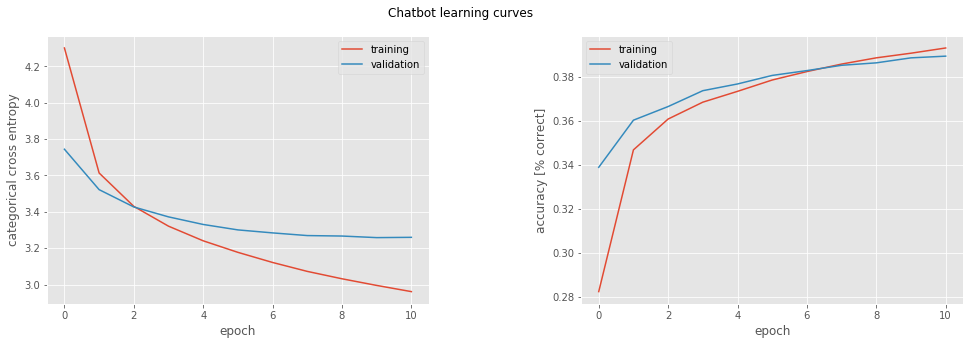

In [129]:
fig_chatbot = plot_history(chatbox_log, "Chatbot learning curves")

<b> Code Adapt your sentence generation code from before so that you can generate an answer given a context sentence from your model. [2 pts] </b>

<b>Code After training, randomly select 10 context-answers pairs from your data and show both the real answer (the one from the data) and the generated one for two different sampling temperatures (e.g. 0.5 and 1.0). [2 pts]</b>

<b>Code Entertain yourself with your model. Write some code to chat with your bot, let it discuss with itself, ... be creative! [2 bonus pts]</b>

In [130]:
def chat_with_bot(model, query, dict_mapping, max_len=25, temperature=1.0):
    input_query = np.array([[dict_mapping.index(word) for word in query]])
    input_query = pad_sequences(input_query, maxlen=max_len, padding='post', truncating='post')
    
    response = [[dict_mapping.index('START')]]
    response = pad_sequences(response, maxlen=max_len-1, padding='post', truncating='post')
    
    response_words = []
    
    for i in range(max_len-2):
        preds = model.predict([input_query, response])
        next_word = sample(preds[0][i], temperature)
        
        if next_word == dict_mapping.index('END'):
            break
        response[0, i+1] = next_word
        response_words.append(dict_mapping[next_word])
    
    return " ".join(response_words)

In [131]:
# Random 10 contex-answer pairs
index = np.random.permutation(len(q_orig))[:10]
print("Temperature: 0.5")
for i in range(10):
    answer_bot = chat_with_bot(Chatbot, q_orig[index[i]].split(), dict_mapping, temperature=0.5)
    true_answer = a_orig[index[i]]
    print("\nQuestion:      {}\nAnswer by bot: {}\nTrue answer:   {}".format(q_orig[index[i]], answer_bot, true_answer))

Temperature: 0.5

Question:      yeah i really like dogs and cats they are my favorite
Answer by bot: i do not like to go out much . i am a mom and i have a dog
True answer:   i wish i had a pet but i work too much

Question:      well i am sure your dad is just looking out for you
Answer by bot: i would love to be a doctor , but i am sure .
True answer:   i really needed to pass the test

Question:      nah not really . i exercise indoors doing yoga so winter sports no big deal
Answer by bot: i love to read comic books .
True answer:   oh but the cold is so wonderful

Question:      well , if you can . . i suggest living next to a park or golf course its so nice !
Answer by bot: i am actually a stay in school .
True answer:   its going great just left work

Question:      hi lucy . its that time , winter . i just love the snow and the cold .
Answer by bot: i do not like to do that
True answer:   i am a summer kinda girl . surfer girl . what are your hobbies .

Question:      i like re

In [132]:
# Random 10 contex-answer pairs
index = np.random.permutation(len(q_orig))[:10]
print("Temperature: 1.0")

for i in range(10):
    answer_bot = chat_with_bot(Chatbot, q_orig[index[i]].split(), dict_mapping, temperature=1.0)
    true_answer = a_orig[index[i]]
    print("\nQuestion:      {}\nAnswer by bot: {}\nTrue answer:   {}".format(q_orig[index[i]], answer_bot, true_answer))

Temperature: 1.0

Question:      i love it because i can find it where i live easily .
Answer by bot: what do you do for a living ?
True answer:   that is great . i like to read draw

Question:      nice . my mom dances ballet .
Answer by bot: sorry to hear that . that sounds fun . i want to help now the others
True answer:   are you actually in high school

Question:      i sometimes like to hang around in bars . plus pancakes i guess .
Answer by bot: basket ball is a lot of adventure and take care
True answer:   i have a huge craving for pancakes right now

Question:      ah cool . i am a teacher actually . really .
Answer by bot: i like to be in sweden , which are you into ?
True answer:   i just turned 10 my mother is a teacher too

Question:      i like country music the most but jazz and hip hop are cool too
Answer by bot: ok its nice to give you with me a comic book .
True answer:   right on . what is your favorite food ? mine is pizza , my grandma makes the best

Question:     

In [133]:
def self_talking(model, init_thought, dict_mapping, temperature=0.75, conversation_len=100):
    answer = init_thought
    
    print("Person 1: {}".format(init_thought))
    for i in range(conversation_len):
        if i%2 == 0:
            person = "Person 2"
        else:
            person = "Person 1"
        answer = chat_with_bot(Chatbot, answer.split(), dict_mapping, temperature=temperature)
        print("{}: {}".format(person, answer))

In [134]:
self_talking(Chatbot, "hi !", dict_mapping)

Person 1: hi !
Person 2: hello ! how are you ?
Person 1: i am good . i just got done with my dogs .
Person 2: that sounds like fun ! i am sorry for my birthday
Person 1: i have two kids and kids are organized to keep too busy .
Person 2: that is very cool . where do you live ?
Person 1: i was in chicago i am going to a movie theatre , but have been to a van
Person 2: are you a teacher ? i am a stay at home mom . i love it .
Person 1: i am not sure you can .
Person 2: i am a way so i have a bunch and cats , but i do not
Person 1: i am a country person , especially waking up !
Person 2: what do you do for a living ?
Person 1: i work at a band in the park
Person 2: i like to cook but i am a vegan too .
Person 1: what is it going to be ?
Person 2: i am from texas and thinking of the anniversary of my 4 dogs .
Person 1: wow , i am so old . i am a financial analyst , but they are so great .
Person 2: i am a beach student , i want to take a break from school .
Person 1: that is great . my dad